In [2]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import numpy as np
import pyopencl as cl

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"


Populating the interactive namespace from numpy and matplotlib


In [3]:
#Create OpenCL context
cl_ctx = cl.create_some_context()

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

In [5]:
%%cl_kernel 
__kernel void heat_eq_2D(__global float *u1, __global const float *u0, float kappa, float dt, float dx, float dy) {
    
    //Inicializacion variables
    int i = get_global_id(0);
    int j = get_global_id(1);
    int nx = get_global_size(0);
    int ny = get_global_size(1);
    
    //Indices vecinos
    int center = j*nx+i;
    int north = (j+1)*nx+i;
    int south = (j-1)*nx+i;
    int east = j*nx+(i+1);
    int west = j*nx +(i-1);
    
    if(i>0 && i<nx-1 && j>0 && j<ny-1){
        u1[center] = u0[center] + kappa*dt/(dx*dx) * (u0[west] -2*u0[center]+u0[east]) + kappa *dt/(dy*dy) * (u0[south] - 2*u0[center] + u0[north]);;
        
    }
    else { 
        u1[center] = u0[center];
    }
}


/usr/local/lib/python2.7/dist-packages/pyopencl-2015.1-py2.7-linux-x86_64.egg/pyopencl/__init__.py:59: CompilerWarning: From-source build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz' on 'Intel(R) OpenCL' at 0x33b4578> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <heat_eq_2D> was successfully vectorized (4)
Done.
  warn(text, CompilerWarning)


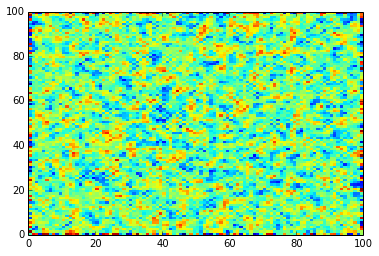

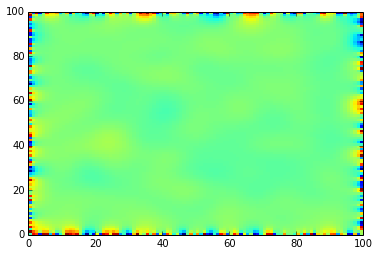

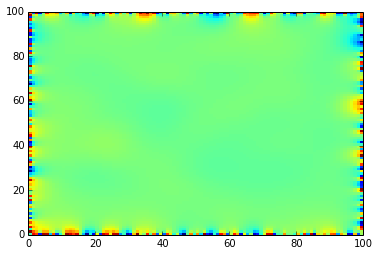

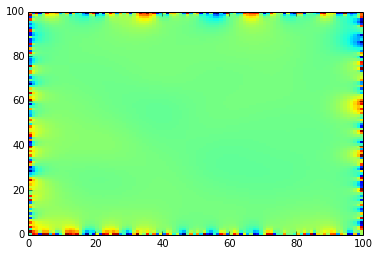

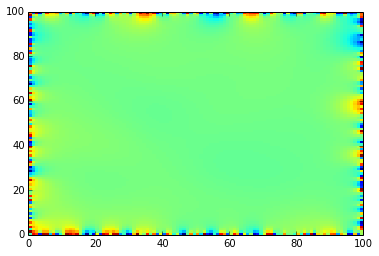

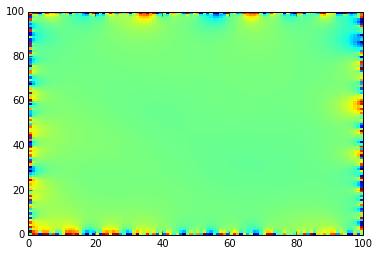

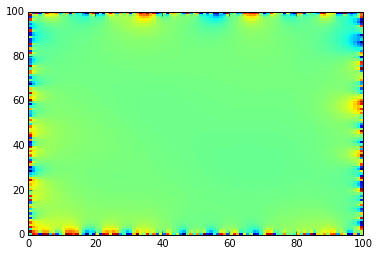

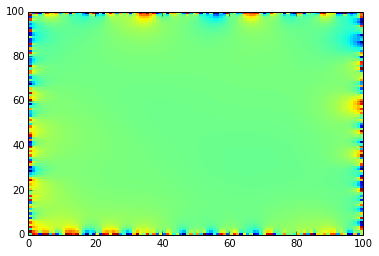

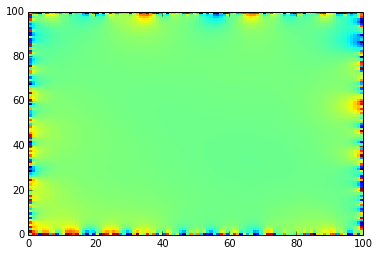

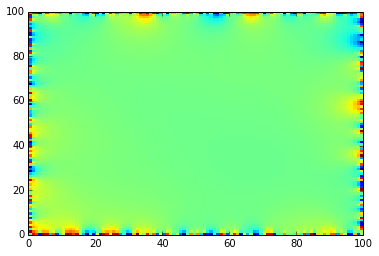

In [7]:
#Find number of cells
nx = 100
ny = 100
#Create test input data

u0 = np.random.rand(ny,nx).astype(np.float32)
kappa = 1.0
dx = 1.0
dy = 1.0
dt = 0.4 * min(dx*dx/(2.0*kappa), dy*dy/(2.0*kappa))

        
mf = cl.mem_flags 
        
#Upload data to the device
u0_g = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
        
#Allocate output buffers
u1_g = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)

#Plot initial conditions



nt = 500
for i in range(0, nt):

   
    heat_eq_2D(cl_queue, (nx,ny), None,u1_g, u0_g, numpy.float32(kappa), numpy.float32(dt), numpy.float32(dx), numpy.float32(dy))
    u0_g, u1_g = u1_g, u0_g
    
    if(i%50==0):
        figure()
        #Download data
        u0 = np.empty((nx, ny), dtype=np.float32)
        cl.enqueue_copy(cl_queue, u0, u0_g)
        pcolor(u0)
